In [17]:
import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm
from shapely.geometry import Point,box
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
def df_to_shapefile(df, output_path, epsg=4326, batch_size=10000):
    '''将 DataFrame 转换为 shapefile'''
    if 'lon' not in df.columns or 'lat' not in df.columns:
        raise ValueError("DataFrame must contain 'lon' and 'lat' columns")
    
    # 初始化一个空的 GeoDataFrame，并设置几何列
    combined_geo_df = gpd.GeoDataFrame(columns=df.columns.tolist() + ['geometry'])
    combined_geo_df.set_geometry('geometry', inplace=True)
    combined_geo_df.set_crs(epsg=epsg, inplace=True)

    total_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    df_iterator = (df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size))
    
    for batch_df in tqdm(df_iterator, total=total_batches, desc="Processing batches"):
        geometry = [Point(xy) for xy in zip(batch_df['lon'], batch_df['lat'])]
        batch_geo_df = gpd.GeoDataFrame(batch_df, geometry=geometry)
        batch_geo_df.set_crs(epsg=epsg, inplace=True)
        combined_geo_df = pd.concat([combined_geo_df, batch_geo_df], ignore_index=True)
    
    combined_geo_df.to_file(output_path, driver='ESRI Shapefile')


In [18]:
os.chdir(r'E:\SETP_ICESat-2数据\ATL_03')
SETP_SHP = r"E:\SETP_Boundary.geojson"

SETP_H5 = pd.read_hdf("测试\ATL03_SETPGL_ALL_0.h5", key='df')
# df_to_shapefile(SETP_H5,'测试\SETP_ALT03_SAMPLE4.shp')
print('包含的冰湖唯一代码={}'.format(SETP_H5['Sort'].unique()))

包含的冰湖唯一代码=[10157.  5965.  5966.  2235.  1041.]


In [19]:
len(SETP_H5)

12847

In [5]:
Sample = SETP_H5[(SETP_H5.Sort==3201) & (SETP_H5.subgroup=='gt1l/')]
Sample = SETP_H5

In [14]:
Sample.signal_conf_combined

0        [0, -1, -1, 0, 0]
1        [0, -1, -1, 0, 0]
2        [0, -1, -1, 0, 0]
3        [0, -1, -1, 0, 0]
4        [0, -1, -1, 0, 0]
               ...        
60533    [0, -1, -1, 0, 0]
60534    [0, -1, -1, 0, 0]
60535    [0, -1, -1, 0, 0]
60536    [0, -1, -1, 0, 0]
60537    [0, -1, -1, 0, 0]
Name: signal_conf_combined, Length: 60538, dtype: object

In [15]:
Sample['signal_conf_combined'].apply(lambda x: any(i > 0 for i in x))

0        False
1        False
2        False
3        False
4        False
         ...  
60533    False
60534    False
60535    False
60536    False
60537    False
Name: signal_conf_combined, Length: 60538, dtype: bool

In [10]:
Sample['signal_conf_combined'] = Sample.apply(lambda row: [row['signal_conf_ph_1'],
                                                   row['signal_conf_ph_2'],
                                                   row['signal_conf_ph_3'],
                                                   row['signal_conf_ph_4'],
                                                   row['signal_conf_ph_5']], axis=1)

In [140]:
filtered_samples = Sample[(Sample['signal_conf_ph_1'] > 0) |
                          (Sample['signal_conf_ph_2'] > 0) |
                          (Sample['signal_conf_ph_3'] > 0) |
                          (Sample['signal_conf_ph_4'] > 0) |
                          (Sample['signal_conf_ph_5'] > 0)]

result_df = pd.DataFrame({'unique_sorts': filtered_samples['Sort'].unique()})

result_df['area_pre_values'] = result_df['unique_sorts'].map(
    lambda sort: filtered_samples[filtered_samples['Sort'] == sort]['Area_pre'].values[0]
)

print(result_df)

    unique_sorts  area_pre_values
0         3201.0         0.014160
1         9421.0         0.002419
2         9422.0         0.002261
3         6943.0         0.014225
4         5098.0         0.577082
5          957.0         0.039057
6          939.0         0.050628
7         2911.0         0.004597
8         8833.0         0.004112
9          913.0         0.042727
10        6846.0         0.076498
11        7021.0         0.046900
12        7020.0         0.009165
13        6996.0         0.027748
14       10754.0         0.003326
15        2929.0         0.005083


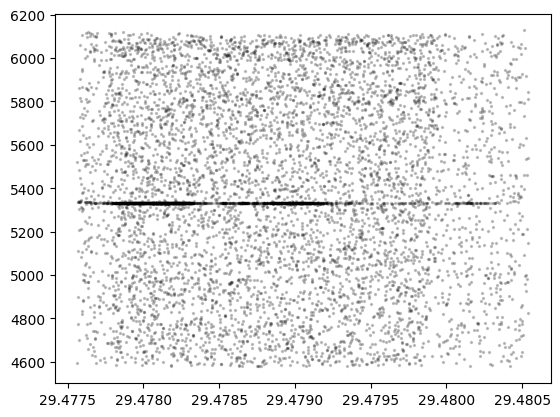

In [110]:
test = Sample[Sample['Sort'] == 957]

plt.scatter(test.lat, test.height, s=2, color='black', alpha=0.2, label='ATL03')

In [62]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
Sample = Sample.copy()
Sample.rename(columns={'height': 'h'}, inplace=True)
class dataCollector:
    def __init__(self, datatype=[],dataDF_list=[]):
        if 'ATL_03' in datatype:
            self.atl03 = dataDF_list[datatype.index('ATL_03')]
        if 'ATL_06' in datatype:
            self.atl06 = dataDF_list[datatype.index('ATL_06')]
        if 'ATL_07' in datatype:
            self.atl07 = dataDF_list[datatype.index('ATL_07')]
        if 'ATL_08' in datatype:
            self.atl08 = dataDF_list[datatype.index('ATL_08')]
        if 'ATL_10' in datatype:
            self.atl10 = dataDF_list[datatype.index('ATL_10')]
        if 'ATL_12' in datatype:
            self.atl12 = dataDF_list[datatype.index('ATL_12')]
        if 'ATL_13' in datatype:
            self.atl13 = dataDF_list[datatype.index('ATL_13')]

    def plotData(self,ax=None,title='some cool ICESat-2 data I found on OpenAltimetry', closefig=True):

        try:
            
            # get data if not already there
            if 'atl03' not in vars(self).keys(): 
                print('Data has not yet been requested from OpenAltimetry yet. Doing this now.')
                self.requestData(verbose=True)

            axes_not_specified = True if ax == None else False

            # create the figure and axis
            if axes_not_specified:
                fig, ax = plt.subplots(figsize=[8,5])
                
            if 'atl03' in vars(self).keys():
                if len(self.atl03) > 0:
                    atl03 = ax.scatter(self.atl03.lat, self.atl03.h, s=2, color='black', alpha=0.2, label='ATL03')
            if 'atl06' in vars(self).keys():
                if len(self.atl06) > 0:
                    atl06, = ax.plot(self.atl06.lat, self.atl06.h, c='C0', linestyle='-', label='ATL06')
            if 'atl07' in vars(self).keys(): 
                if len(self.atl07) > 0:
                    atl07, = ax.plot(self.atl07.lat, self.atl07.h, c='C2', linestyle='--', label='ATL07')
            if 'atl08' in vars(self).keys():
                if len(self.atl08) > 0:
                    atl08, = ax.plot(self.atl08.lat, self.atl08.h, c='C1', linestyle=':', label='ATL08')
                    try:
                        if np.sum(~np.isnan(self.atl08.canopy))>0:
                            atl08canopy = ax.scatter(self.atl08.lat, self.atl08.h+self.atl08.canopy, s=5, c='C1', label='ATL08 canopy')
                    except: 
                        print('could not display ATL08 canopy data')
            if 'atl10' in vars(self).keys():
                if len(self.atl10) > 0:
                    atl10, = ax.plot(self.atl10.lat, self.atl10.h, c='C3', linestyle='-', label='ATL10')
            if 'atl12' in vars(self).keys():   
                if len(self.atl12) > 0:
                    atl12, = ax.plot(self.atl12.lat, self.atl12.h, c='C4', linestyle='--', label='ATL12')
            if 'atl13' in vars(self).keys():
                if len(self.atl13) > 0:
                    atl13, = ax.plot(self.atl13.lat, self.atl13.h, c='C5', linestyle=':', label='ATL13')

            try:
                prodlist = [v for v in vars(self).keys() if (('atl' in v) & (len(v)==5) & ('atl03' not in v))]
                maxs = [vars(self)[k].h.max() for k in prodlist]
                mins = [vars(self)[k].h.min() for k in prodlist]
                maxprods = np.nanmax(maxs)
                minprods = np.nanmin(mins)
                hrange = maxprods - minprods
                y_min = minprods - hrange * 0.5
                y_max = maxprods + hrange * 0.5
                ax.set_ylim((y_min, y_max))
            except:
                heights = self.atl03.h[self.atl03.conf != 'Noise']
                y_min = np.min(heights)
                y_max = np.max(heights)
                ax.set_ylim((y_min, y_max))

            x_min = self.atl03.lat.min()
            x_max = self.atl03.lat.max()
            ax.set_xlim((x_min, x_max))

            # label the axes
            ax.set_title(title)
            ax.set_xlabel('latitude')
            ax.set_ylabel('elevation in meters')

            # add a legend
            ax.legend(loc='upper right')

            # add some text to provide info on what is plotted
            info = 'ICESat-2 track {track:d}-{beam:s} on {date:s} ({lon:.4f}E, {lat:.4f}N)'.format(track=self.track, 
                                                                                                    beam=self.beam, 
                                                                                                    date=self.date, 
                                                                                                    lon=np.mean(self.lonlims), 
                                                                                                    lat=np.mean(self.latlims))
            infotext = ax.text(0.02, 0.97, info,
                                horizontalalignment='left', 
                                verticalalignment='top', 
                                transform=ax.transAxes,
                                fontsize=7,
                                bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

            if axes_not_specified:
                fig.tight_layout()
                if closefig:
                    plt.close(fig)
                return fig
            else:
                return ax
                
        except:
            print('Plotting the ICESat-2 data was unsuccessful.')
            traceback.print_exc()

Plotting the ICESat-2 data was unsuccessful.


Traceback (most recent call last):
  File "C:\Users\A\AppData\Local\Temp\ipykernel_14600\1755438969.py", line 69, in plotData
    maxprods = np.nanmax(maxs)
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\GEE\Lib\site-packages\numpy\lib\nanfunctions.py", line 483, in nanmax
    res = np.amax(a, axis=axis, out=out, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\GEE\Lib\site-packages\numpy\core\fromnumeric.py", line 2827, in amax
    return _wrapreduction(a, np.maximum, 'max', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\GEE\Lib\site-packages\numpy\core\fromnumeric.py", line 88, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: zero-size array to reduction operation maximum which has no identity

During handling of the above exception, anothe

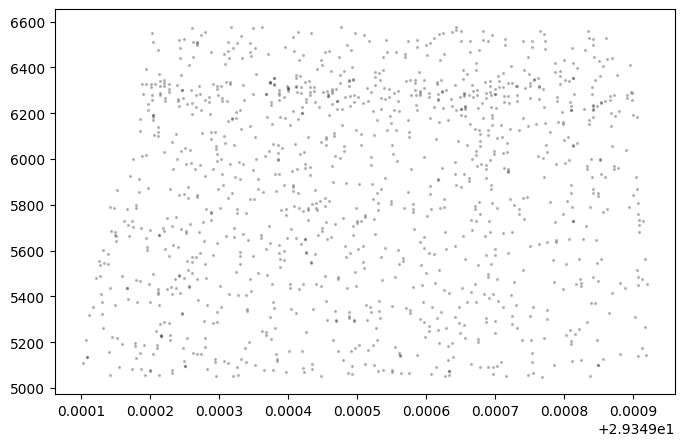

In [63]:
s = dataCollector(datatype=['ATL_03'],dataDF_list=[Sample])
s.plotData()